Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    return df

def handle_missing_values(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_imputer = SimpleImputer(strategy='median')
    df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

    categorical_columns = df.select_dtypes(include=['object']).columns
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

    return df

def encode_categorical_variables(df):
    label_encoder = LabelEncoder()
    categorical_columns = [
        'Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage',
        'differentiate', 'Grade', 'A Stage', 'Estrogen Status',
        'Progesterone Status', 'Status'
    ]

    encoded_df = df.copy()
    for column in categorical_columns:
        if column in encoded_df.columns:
            encoded_df[column] = label_encoder.fit_transform(encoded_df[column].astype(str))

    return encoded_df

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

def standardize_features(df):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_features, columns=df.columns)
    return scaled_df

def apply_pca(df, n_components=None, variance_threshold=0.95):
    if n_components is None:
        pca = PCA()
        pca.fit(df)
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
        pca = PCA(n_components=n_components)
    else:
        pca = PCA(n_components=n_components)

    transformed_data = pca.fit_transform(df)
    columns = [f'PC{i+1}' for i in range(n_components)]
    transformed_df = pd.DataFrame(transformed_data, columns=columns)

    return transformed_df, pca, pca.explained_variance_ratio_

def plot_explained_variance(explained_variance_ratio):
    plt.figure(figsize=(10, 6))
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs Number of Components')
    plt.grid(True)
    plt.savefig('pca_explained_variance.png')
    plt.close()

def main():
    print("Loading data...")
    input_file = "Breast_Cancer_dataset.csv"
    df = load_data(input_file)
    original_shape = df.shape

    target = df['Status'].copy()
    df = df.drop('Status', axis=1)

    print("Handling missing values...")
    df = handle_missing_values(df)

    print("Encoding categorical variables...")
    df = encode_categorical_variables(df)

    print("Removing outliers...")
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df = remove_outliers(df, numeric_columns)

    print("Standardizing features...")
    df_scaled = standardize_features(df)

    print("Applying PCA...")
    transformed_df, pca, explained_variance_ratio = apply_pca(df_scaled)

    plot_explained_variance(explained_variance_ratio)

    final_df = transformed_df.copy()
    final_df['Status'] = target[transformed_df.index]

    output_file = "preprocessed_breast_cancer_data.csv"
    final_df.to_csv(output_file, index=False)

    print("\nPreprocessing Summary:")
    print(f"Original dataset shape: {original_shape}")
    print(f"Preprocessed dataset shape: {final_df.shape}")
    print(f"\nNumber of PCA components: {transformed_df.shape[1]}")
    print("\nExplained variance ratio by component:")
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"PC{i+1}: {ratio:.4f}")
    print(f"\nTotal variance explained: {sum(explained_variance_ratio):.4f}")

    print("\nMissing values in preprocessed data:")
    print(final_df.isnull().sum())

    print("\nSaved preprocessed data to:", output_file)
    print("Saved PCA explained variance plot to: pca_explained_variance.png")

if __name__ == "__main__":
    main()

Loading data...
Handling missing values...
Encoding categorical variables...
Removing outliers...
Standardizing features...
Applying PCA...

Preprocessing Summary:
Original dataset shape: (4024, 16)
Preprocessed dataset shape: (1328, 7)

Number of PCA components: 6

Explained variance ratio by component:
PC1: 0.3155
PC2: 0.2005
PC3: 0.1454
PC4: 0.1054
PC5: 0.0962
PC6: 0.0895

Total variance explained: 0.9525

Missing values in preprocessed data:
PC1       0
PC2       0
PC3       0
PC4       0
PC5       0
PC6       0
Status    0
dtype: int64

Saved preprocessed data to: preprocessed_breast_cancer_data.csv
Saved PCA explained variance plot to: pca_explained_variance.png


Modeling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf

class KNNFromScratch:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        predictions = []
        for x in X:
            distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]

            k_indices = np.argsort(distances)[:self.k]

            k_nearest_labels = self.y_train[k_indices]

            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)

        return np.array(predictions)

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)

    plot_confusion_matrix(cm, f"{model_name} Confusion Matrix")

    return accuracy, cm, report

def main():
    print("Loading preprocessed data...")
    df = pd.read_csv("preprocessed_breast_cancer_data.csv")

    X = df.drop('Status', axis=1).values
    y = df['Status'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    results = {}

    #KNN
    print("\nTraining KNN from scratch...")
    knn = KNNFromScratch(k=5)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    results['KNN'] = evaluate_model(y_test, y_pred_knn, "KNN")

    #Naive Bayes
    print("\nTraining Naive Bayes...")
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred_nb = nb.predict(X_test)
    results['Naive Bayes'] = evaluate_model(y_test, y_pred_nb, "Naive Bayes")

    #C4.5 Decision Tree
    print("\nTraining Decision Tree...")
    dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    results['Decision Tree'] = evaluate_model(y_test, y_pred_dt, "Decision Tree")

    #Random Forest
    print("\nTraining Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['Random Forest'] = evaluate_model(y_test, y_pred_rf, "Random Forest")

    #Gradient Boosting
    print("\nTraining Gradient Boosting...")
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    results['Gradient Boosting'] = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

    #Neural Network
    print("\nTraining Neural Network...")
    nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    nn.fit(X_train, y_train)
    y_pred_nn = nn.predict(X_test)
    results['Neural Network'] = evaluate_model(y_test, y_pred_nn, "Neural Network")

    print("\nModel Comparison:")
    accuracies = {model: result[0] for model, result in results.items()}

    plt.figure(figsize=(10, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Accuracies Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.close()

    comparison_df = pd.DataFrame({
        'Model': accuracies.keys(),
        'Accuracy': accuracies.values()
    })
    comparison_df.to_csv('model_comparison.csv', index=False)

    print("\nResults saved to 'model_comparison.csv'")
    print("Confusion matrices and model comparison plots have been saved as PNG files")

if __name__ == "__main__":
    main()

Loading preprocessed data...

Training KNN from scratch...

KNN Results:
Accuracy: 0.7895

Confusion Matrix:
[[208  16]
 [ 40   2]]

Classification Report:
              precision    recall  f1-score   support

       Alive       0.84      0.93      0.88       224
        Dead       0.11      0.05      0.07        42

    accuracy                           0.79       266
   macro avg       0.47      0.49      0.47       266
weighted avg       0.72      0.79      0.75       266


Training Naive Bayes...

Naive Bayes Results:
Accuracy: 0.8421

Confusion Matrix:
[[224   0]
 [ 42   0]]

Classification Report:
              precision    recall  f1-score   support

       Alive       0.84      1.00      0.91       224
        Dead       0.00      0.00      0.00        42

    accuracy                           0.84       266
   macro avg       0.42      0.50      0.46       266
weighted avg       0.71      0.84      0.77       266



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Decision Tree...

Decision Tree Results:
Accuracy: 0.7030

Confusion Matrix:
[[182  42]
 [ 37   5]]

Classification Report:
              precision    recall  f1-score   support

       Alive       0.83      0.81      0.82       224
        Dead       0.11      0.12      0.11        42

    accuracy                           0.70       266
   macro avg       0.47      0.47      0.47       266
weighted avg       0.72      0.70      0.71       266


Training Random Forest...

Random Forest Results:
Accuracy: 0.8308

Confusion Matrix:
[[220   4]
 [ 41   1]]

Classification Report:
              precision    recall  f1-score   support

       Alive       0.84      0.98      0.91       224
        Dead       0.20      0.02      0.04        42

    accuracy                           0.83       266
   macro avg       0.52      0.50      0.47       266
weighted avg       0.74      0.83      0.77       266


Training Gradient Boosting...

Gradient Boosting Results:
Accuracy: 0.8383

C

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Network Results:
Accuracy: 0.7218

Confusion Matrix:
[[189  35]
 [ 39   3]]

Classification Report:
              precision    recall  f1-score   support

       Alive       0.83      0.84      0.84       224
        Dead       0.08      0.07      0.07        42

    accuracy                           0.72       266
   macro avg       0.45      0.46      0.46       266
weighted avg       0.71      0.72      0.72       266


Model Comparison:

Results saved to 'model_comparison.csv'
Confusion matrices and model comparison plots have been saved as PNG files


Hyperparameters

Loading preprocessed data...

Performing Grid Search for Decision Tree...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Performing Grid Search for Neural Network...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Decision Tree Results:
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation score: 0.827683615819209

Test Set Performance:
Accuracy: 0.8270676691729323


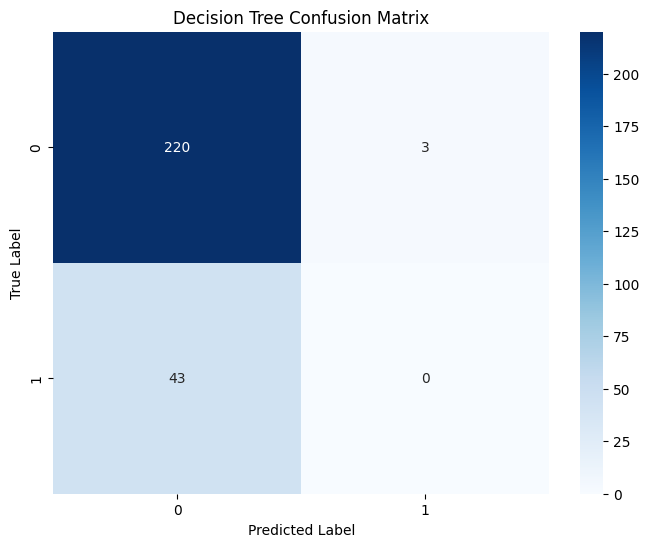


Classification Report:
              precision    recall  f1-score   support

       Alive       0.84      0.99      0.91       223
        Dead       0.00      0.00      0.00        43

    accuracy                           0.83       266
   macro avg       0.42      0.49      0.45       266
weighted avg       0.70      0.83      0.76       266


Neural Network Results:
Best parameters: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 300}
Best cross-validation score: 0.8342749529190208

Test Set Performance:
Accuracy: 0.8383458646616542


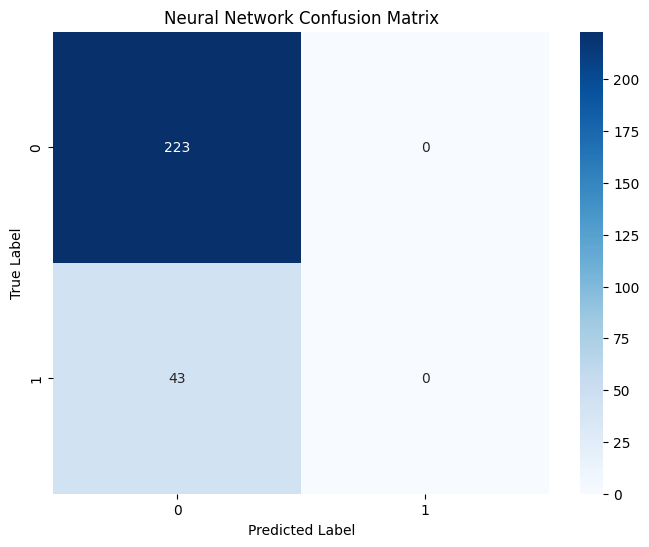


Classification Report:
              precision    recall  f1-score   support

       Alive       0.84      1.00      0.91       223
        Dead       0.00      0.00      0.00        43

    accuracy                           0.84       266
   macro avg       0.42      0.50      0.46       266
weighted avg       0.70      0.84      0.76       266


Results saved to 'hyperparameter_tuning_results.csv'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

def main():
    # Load preprocessed data
    print("Loading preprocessed data...")
    df = pd.read_csv("preprocessed_breast_cancer_data.csv")

    # Separate features and target
    X = df.drop('Status', axis=1).values
    y = df['Status'].values

    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Decision Tree parameter grid
    dt_param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Neural Network parameter grid
    nn_param_grid = {
        'hidden_layer_sizes': [(50,), (100,)],
        'learning_rate_init': [0.001, 0.01],
        'max_iter': [300]
    }

    # 1. Decision Tree Grid Search
    print("\nPerforming Grid Search for Decision Tree...")
    dt = DecisionTreeClassifier(random_state=42)
    dt_grid = GridSearchCV(
        dt,
        dt_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    dt_grid.fit(X_train, y_train)

    # 2. Neural Network Grid Search
    print("\nPerforming Grid Search for Neural Network...")
    nn = MLPClassifier(random_state=42, activation='relu')
    nn_grid = GridSearchCV(
        nn,
        nn_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    nn_grid.fit(X_train, y_train)

    # Print results for both models
    models = {
        'Decision Tree': dt_grid,
        'Neural Network': nn_grid
    }

    for name, model in models.items():
        print(f"\n{name} Results:")
        print("Best parameters:", model.best_params_)
        print("Best cross-validation score:", model.best_score_)

        y_pred = model.predict(X_test)
        print("\nTest Set Performance:")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    results_df = pd.DataFrame({
        'Model': ['Decision Tree', 'Neural Network'],
        'Best Parameters': [str(dt_grid.best_params_), str(nn_grid.best_params_)],
        'Best CV Score': [dt_grid.best_score_, nn_grid.best_score_],
        'Test Accuracy': [
            accuracy_score(y_test, dt_grid.predict(X_test)),
            accuracy_score(y_test, nn_grid.predict(X_test))
        ]
    })

    results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
    print("\nResults saved to 'hyperparameter_tuning_results.csv'")

def plot_confusion_matrix(cm, title):
    """Plot confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'],
                yticklabels=['0', '1'])
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.close()

def main():
    print("Loading preprocessed data...")
    df = pd.read_csv("preprocessed_breast_cancer_data.csv")

    X = df.drop('Status', axis=1).values
    y = df['Status'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    #Decision Tree parameter using grid
    dt_param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    #Neural Network parameter using grid
    nn_param_grid = {
        'hidden_layer_sizes': [(50,), (100,)],
        'learning_rate_init': [0.001, 0.01],
        'max_iter': [300]
    }

    #Decision Tree
    print("\nPerforming Grid Search for Decision Tree...")
    dt = DecisionTreeClassifier(random_state=42)
    dt_grid = GridSearchCV(
        dt,
        dt_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    dt_grid.fit(X_train, y_train)

    #Neural Network
    print("\nPerforming Grid Search for Neural Network...")
    nn = MLPClassifier(random_state=42, activation='relu')
    nn_grid = GridSearchCV(
        nn,
        nn_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    nn_grid.fit(X_train, y_train)

    #both models
    models = {
        'Decision Tree': dt_grid,
        'Neural Network': nn_grid
    }

    for name, model in models.items():
        print(f"\n{name} Results:")
        print("Best parameters:", model.best_params_)
        print("Best cross-validation score:", model.best_score_)

        y_pred = model.predict(X_test)

        print("\nTest Set Performance:")
        print("Accuracy:", accuracy_score(y_test, y_pred))

        #confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, name)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    results_df = pd.DataFrame({
        'Model': ['Decision Tree', 'Neural Network'],
        'Best Parameters': [str(dt_grid.best_params_), str(nn_grid.best_params_)],
        'Best CV Score': [dt_grid.best_score_, nn_grid.best_score_],
        'Test Accuracy': [
            accuracy_score(y_test, dt_grid.predict(X_test)),
            accuracy_score(y_test, nn_grid.predict(X_test))
        ]
    })

    results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
    print("\nResults saved to 'hyperparameter_tuning_results.csv'")

if __name__ == "__main__":
    main()

Feature Importance

Loading preprocessed data...

Calculating feature importance for KNN...

Calculating feature importance for Naive Bayes...

Calculating feature importance for Decision Tree...

Calculating feature importance for Random Forest...

Calculating feature importance for Gradient Boosting...

Calculating feature importance for Neural Network...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Feature Importance Rankings:
          KNN  Naive Bayes  Decision Tree  Random Forest  Gradient Boosting  \
PC3 -0.016165          0.0       0.175694       0.177505           0.207178   
PC2 -0.019173          0.0       0.183618       0.164804           0.188043   
PC5 -0.006767          0.0       0.176043       0.170836           0.170435   
PC6 -0.012406          0.0       0.163123       0.166323           0.164060   
PC1 -0.020677          0.0       0.168977       0.162110           0.167091   
PC4 -0.017669          0.0       0.132544       0.158421           0.103194   

     Neural Network  Mean Importance  
PC3        0.000376         0.090765  
PC2       -0.000752         0.086090  
PC5        0.000000         0.085091  
PC6        0.000000         0.080183  
PC1        0.000000         0.079584  
PC4        0.001880         0.063062  

Feature importance rankings saved to 'feature_importance.csv'


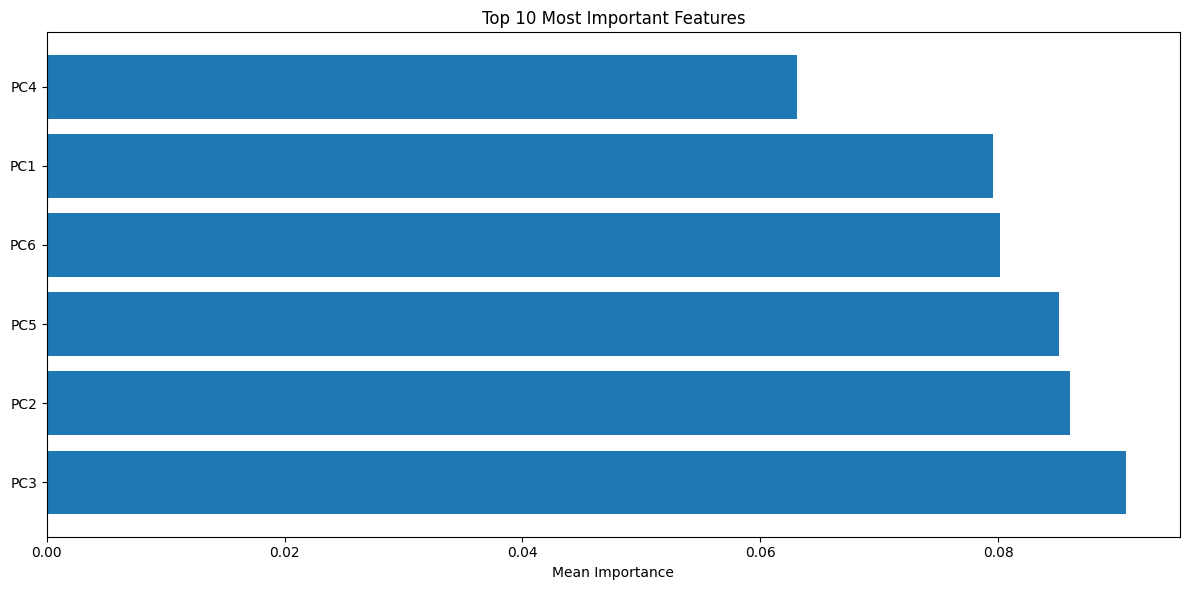

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def get_feature_importance(models, X, y, feature_names):
    importance_df = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name, model in models.items():
        print(f"\nCalculating feature importance for {name}...")

        model.fit(X_train, y_train)

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
            importances = result.importances_mean

        importance_df[name] = importances

    importance_df.index = feature_names
    importance_df['Mean Importance'] = importance_df.mean(axis=1)
    importance_df = importance_df.sort_values('Mean Importance', ascending=False)

    return importance_df

def plot_feature_importance(importance_df, top_n=10):
    plt.figure(figsize=(12, 6))

    top_features = importance_df.head(top_n)
    plt.barh(range(len(top_features)), top_features['Mean Importance'])
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Mean Importance')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

def main():
    print("Loading preprocessed data...")
    df = pd.read_csv("preprocessed_breast_cancer_data.csv")

    X = df.drop('Status', axis=1)
    y = df['Status']

    #Initialize all models
    models = {
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Neural Network': MLPClassifier(random_state=42)
    }

    #feature importance
    importance_df = get_feature_importance(models, X.values, y, X.columns)

    print("\nFeature Importance Rankings:")
    print(importance_df)

    importance_df.to_csv('feature_importance.csv')
    print("\nFeature importance rankings saved to 'feature_importance.csv'")

    plot_feature_importance(importance_df)

if __name__ == "__main__":
    main()